# ISSM "square ice shelf" tutorial (with moving front)

Based off of square ice shelf tutorial, but incorporating a moving front. 

## Imports

In [1]:
########################
### "normal" imports ###
########################

import numpy as np
import matplotlib.pyplot as plt
from shapely import LineString
from shapely.geometry import Point, Polygon
import tqdm

######################
### ISSM functions ###
######################

from model import model
from setflowequation import setflowequation
from squaremesh import squaremesh
from InterpFromMeshToMesh2d import InterpFromMeshToMesh2d

################
### my stuff ###
################

from ssa_solver import prognostic_solve, diagnostic_solve, coupled_solve

## Initialize model and mesh domain

In [2]:
md = model()
Lx, Ly = 1e6, 1e6
md = squaremesh(md, Lx, Ly, 150, 100) #squaremesh(model, x, y, nx, ny)
md = setflowequation(md, 'SSA', 'all') #we will apply the SSA over the entire domain

## Describe boundaries and levelsets

ISSM needs to know which parts of the domain are grounded ice, floating ice, terminus boundary, and ocean. Additionally, it will be useful to set up distinct boundary subsets (terminus, sidewalls, and inflow boundary). 

In [3]:
x, y = md.mesh.x, md.mesh.y
x_max, x_min, y_max, y_min = x.max(), x.min(), y.max(), y.min()
x_t = 3/5*Lx #unlike the tutorial, we'll have the shelf terminate before the end of the domain


##########################################
### define the terminus and ice domain ###
##########################################

ys = np.linspace(y_min, y_max, 200)
terminus_curve = LineString([(x_t, y_i) for y_i in ys])
md.miscellaneous.terminus = terminus_curve
tx, ty = np.array(terminus_curve.coords).T

Ω_ice = Polygon([
    (x_min, y_min),
    (x_min, y_max),
    *zip(tx[::-1], ty[::-1]),   # walk down along the terminus
    (x_min, y_min)
])

##############################
### describe the levelsets ###
##############################

dist = np.array([terminus_curve.distance(Point(xi, yi)) for xi, yi in zip(x, y)]) #distance from the terminus curve (unsigned)
inside = np.array([Ω_ice.covers(Point(xi, yi)) for xi, yi in zip(x, y)]) #T/F values for ice domain, for signing the distance
md.mask.ice_levelset = np.where(inside, -dist, dist) #distance from curve, negative on ice, positive off ice, zero on terminus
md.mask.ocean_levelset = -np.ones_like(x) #ocean exists where md.mask.ocean_levelset < 0 

###############################################
### describe additional boundary components ###
###############################################

Γ_inflow = (x == x_min) #inflow boundary on the leftmost boundary
Γ_sidewalls = (y == y_max) | (y == y_min) #sidewalls on the upper and lower boundaries

## Material parameters and initial configuration

In [4]:
##########################
### material densities ###
##########################

ρ_i = md.materials.rho_ice
ρ_w = md.materials.rho_water
ϱ = ρ_i/ρ_w

########################
### initial geometry ###
########################

H_min = 300
H_max = 1000
H = H_max + (H_min - H_max)*(x - x_min)/(x_t - x_min)
H[md.mask.ice_levelset > 0] = 0
s = (1 - ϱ)*H
b = s - H

####################################
### velocity boundary conditions ###
####################################

u = (500, 0)

## Get the instantaneous solution (no timestepping)

In [5]:
u = diagnostic_solve(md, thickness = H, surface = s, temperature = 253.15, friction = 0, velocity = u,
                      dirichlet_x = Γ_inflow | Γ_sidewalls, dirichlet_y = Γ_inflow | Γ_sidewalls)

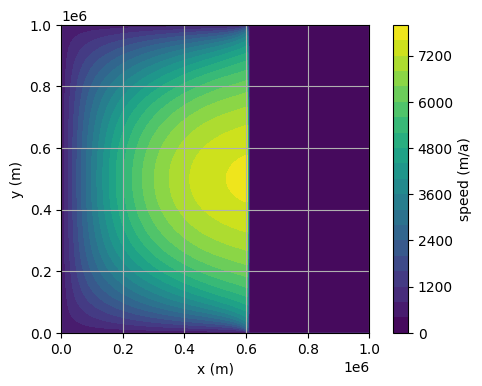

In [6]:
elts = md.mesh.elements - 1
speed_steady = np.hypot(u[0], u[1])

plt.figure(figsize = (6, 4))
plt.tricontourf(x, y, elts, speed_steady, levels = 20)
plt.colorbar(label = 'speed (m/a)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().set_aspect('equal')
plt.grid()
plt.show()

## Transient solution

Using icepack-style timestepping. 

In [7]:
model_time = 50
Δt = 1
num_timesteps = int(model_time/Δt) + 1

opts = {'temperature': 253.15, 'friction': 0, 'dirichlet_x': Γ_inflow | Γ_sidewalls, 'dirichlet_y': Γ_inflow | Γ_sidewalls, 
        'thickness_inflow': H, 'inflow_boundary': Γ_inflow, 'moving_front': True, 'thickness_infill': H_min}

for step in tqdm.trange(num_timesteps):
    # u = diagnostic_solve(md, velocity = u, thickness = H, **opts)
    # H = prognostic_solve(md, Δt, velocity = u, thickness = H, **opts)
    u, H = coupled_solve(md, Δt, velocity = u, thickness = H, **opts)

  0%|                                                                                            | 0/51 [00:00<?, ?it/s]

      no smb.mass_balance specified: values set as zero
      no basalforcings.groundedice_melting_rate specified: values set as zero
      no basalforcings.floatingice_melting_rate specified: values set as zero


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [03:45<00:00,  4.42s/it]


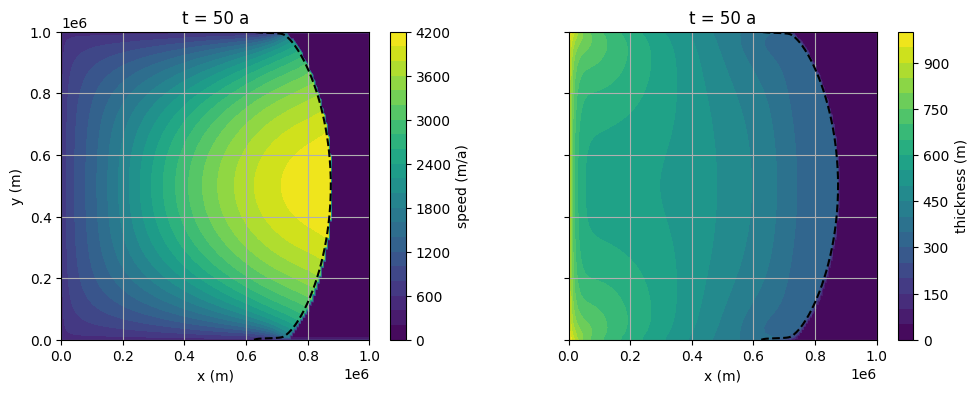

In [8]:
speed = np.hypot(u[0], u[1])
px, py = np.array(md.miscellaneous.terminus.coords).T
H = md.geometry.thickness.flatten()

fig, ax = plt.subplots(1, 2, figsize = (12, 4), sharex = True, sharey = True)

c0 = ax[0].tricontourf(x, y, elts, speed, levels = 20)
ax[0].plot(px, py, color = 'k', linestyle = 'dashed')
fig.colorbar(c0, ax = ax[0], label = 'speed (m/a)')
ax[0].set_title(f't = {model_time:g} a')
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('y (m)')
ax[0].set_aspect('equal')
ax[0].grid()

c1 = ax[1].tricontourf(x, y, elts, H, levels = 20)
ax[1].plot(px, py, color = 'k', linestyle = 'dashed')
fig.colorbar(c1, ax = ax[1], label = 'thickness (m)')
ax[1].set_title(f't = {model_time:g} a')
ax[1].set_xlabel('x (m)')
ax[1].set_aspect('equal')
ax[1].grid()

plt.show()